### Supermarket data science case study - Test en junk notebook for writing data prep pipeline


# 0. Always run step 0

### >> Importing packages

In [1]:
import pandas as pd
import numpy as np

import sys
import altair as alt

import vegafusion as vf

import sklearn

from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline

import time

### >> Functions

In [2]:
def f_concat(l_input):

    # Initialize.
    dummy = ""
    n_len = len(l_input)

    if n_len == 1:
        return l_input[0]

    # Loop through text elements.
    for i in range(n_len - 1):
        dummy = dummy + l_input[i] + ", "

    # Append last element.
    dummy = dummy + "and " + l_input[n_len - 1]

    # Return result.
    return dummy

In [3]:
def basic_description(df):
    print(
        f"-> Contains:                {round(df.shape[0]/1e6, 4)} million observations and has {df.shape[1]} Feature names: {f_concat(df.columns)}.\n"
    )
    print(
        f"-> Has size of              {round(sys.getsizeof(df)/1024/1024/1024, 2)} GB."
    )

In [4]:
def extract_datetime_features(df):
    """
    Extracting datetime features
    year, month, day of month, weekday (1-7), week number-year, week_year_date
    """
    df = df.copy()

    # Ensure the date column is sorted
    df = df.sort_values("date")

    # df["year"] = df["date"].dt.year
    # df["month"] = df["date"].dt.month
    # df["day"] = df["date"].dt.day

    # Adjusting weekday to start from 1 (Monday) to 7 (Sunday)
    df["weekday"] = df["date"].dt.dayofweek + 1

    # Adding week number feature
    df["week_number"] = df["date"].dt.isocalendar().week

    # Adding week number-year feature
    df["week_year"] = df["week_number"].astype(str).str.zfill(2) + df["year"].astype(
        str
    )

    # Convert week_year to datetime with monday as startdate of week
    df["week_year_date"] = pd.to_datetime(
        df["year"].astype(str) + df["week_number"].astype(str).str.zfill(2) + "1",
        format="%Y%W%w",
    )

    # Adding trend feature: number of weeks since the start of the dataset
    start_date = df["date"].min()

    df["weeks_since_start"] = ((df["date"] - start_date).dt.days / 7).astype(int) + 1

    return df

In [5]:
def extract_datetime_features2(df):
    """
    Extracting datetime features:
    year, month, day of month, weekday (1-7), week number-year, and trend (weeks since start, starting at 1)
    """
    # Ensure the date column is sorted
    df = df.copy().sort_values("date")

    # Use isocalendar for consistent week-based calculations

    iso_calendar = df["date"].dt.isocalendar()

    # Year, Month, Day
    # df["year"] = iso_calendar.year
    # df["month"] = df["date"].dt.month
    # df["day"] = df["date"].dt.day

    # Weekday (1 = Monday, 7 = Sunday)
    df["weekday"] = iso_calendar.day

    # Week number
    df["week_number"] = iso_calendar.week

    # Week-year
    df["week_year"] = df["week_number"].astype(str).str.zfill(2) + df["year"].astype(
        str
    )

    # Convert week_year to datetime with monday as startdate of week
    df["week_year_date"] = pd.to_datetime(
        df["year"].astype(str) + df["week_number"].astype(str).str.zfill(2) + "1",
        format="%Y%W%w",
    )

    # First day of the ISO year containing the start date

    start_date = df["date"].min()
    start_year_first_day = datetime(start_date.year, 1, 1)

    # 'search' for first monday of year
    while start_year_first_day.isocalendar()[1] != 1:

        start_year_first_day = start_year_first_day + pd.Timedelta(days=1)

    ##Itemweek number
    # Weeks since start (aligned with ISO week numbers)
    df["weeks_since_start"] = (
        iso_calendar.week + (iso_calendar.year - start_year_first_day.year) * 52
    )

    # Adjust weeks_since_start to start from 1
    df["weeks_since_start"] = (
        df["weeks_since_start"] - df["weeks_since_start"].min() + 1
    )

    return df

### >> Downcast and transform data
Update formatting of features to optimize memory and standardize column names.

In [6]:
def standardize_column_names(s):
    return s.replace(" ", "")


def optimize_memory(df):
    # Change: Objects to Categorical.
    object_cols = df.select_dtypes(include="object").columns

    if not object_cols.empty:
        print("Change: Objects to Categorical")
        df[object_cols] = df[object_cols].astype("category")

    # Change: Convert integers to smallest unsigned integer and floats to smallest.
    for old, new in [("integer", "unsigned"), ("float", "float")]:
        print("Change: " + old + " --> " + new)
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)

    return df


def month_year_to_int(df, i):
    # Change: Month and Year to integer.
    if i == 0:
        print("Change: Month and Year to integer")
        df = df.astype({"month": int, "year": int})

    return df

### >> Transform date-related columns to datetime format.

In [7]:
# # Convert datasets to time series
# def transform_date_to_datetime(df, i):
#     if i == 0:
#         print("Change: Transformed 'year', 'month', 'day' columns to Datetime feature")
#         df["date"] = pd.to_datetime(df[["year", "month", "day"]], unit="us")

#         print(
#             "Change: Dropped 'id', 'month', 'day' columns and transformed to Datetime64[us] feature"
#         )
#         df.drop(columns=["day", "month", "id"], inplace=True)

#     else:
#         if "date" in df.columns:
#             print("Change: Transformed 'date' column to Datetime Dtype")
#             df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

#     return df

In [8]:
import pandas as pd


# Convert datasets to time series
def transform_date_to_datetime(df, i):
    if i == 0:
        print("Change: Transformed 'year', 'month', 'day' columns to Datetime feature")
        # Convert year, month, and day to a single datetime column
        df["date"] = pd.to_datetime(df[["year", "month", "day"]]).dt.floor("D")

        print(
            "Change: Dropped 'id', 'month', 'day' columns and transformed to Datetime feature"
        )
        df.drop(columns=["day", "month", "id"], inplace=True)

    else:
        if "date" in df.columns:
            print("Change: Transformed 'date' column to Datetime Dtype")
            df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None).dt.floor("D")

    return df

### >> Import data from local PATH
Import data trough pipeline to downcast the data and transformations

In [9]:
def f_get_data(i=0):

    # Define path.
    c_path = "C:/Users/alexander/Documents/0. Data Science and AI for Experts/EAISI_4B_Supermarket/data/raw/"

    # Identify file.
    v_file = (
        "history-per-year",  # 0
        "history_aggregated",  # 1
        "holidays_events",  # 2
        "items",  # 3
        "oil",  # 4
        "stores",  # 5
        "transactions",  # 6
    )

    # Load data.
    df = (
        pd.read_parquet(c_path + v_file[i] + ".parquet")
        .rename(columns=standardize_column_names)
        .pipe(optimize_memory)
        .pipe(month_year_to_int, i)
        .pipe(transform_date_to_datetime, i)
    )

    # Return data.
    return df

### >> Importing data

In [10]:
# Sales History per year
df_sales = f_get_data(0)

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
Change: Dropped 'id', 'month', 'day' columns and transformed to Datetime feature


In [11]:
# Holidays
df_holidays = f_get_data(2)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float
Change: Transformed 'date' column to Datetime Dtype


In [12]:
# Items
df_items = f_get_data(3)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float


In [13]:
# Stores
df_stores = f_get_data(5)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float


# 1. Imputing sales data

In [ ]:
df_sales = f_get_data(0)

# df_0 = df_0[df_0["year"].isin([2014, 2015])].drop(columns=['id', 'day','month' ])
df_sales = df_sales.drop(columns=["id", "day", "month"])
print("-" * 50)
df_sales.info()

In [ ]:
# To check how big df wil get after NaN inputing per year
df_sales_2013 = df_sales[(df_sales["year"] == 2013)]
df_sales_2014 = df_sales[(df_sales["year"] == 2014)]
df_sales_2015 = df_sales[(df_sales["year"] == 2015)]
df_sales_2016 = df_sales[(df_sales["year"] == 2016)]
df_sales_2017 = df_sales[(df_sales["year"] == 2017)]

In [ ]:
basic_description(df_sales_2017)  # --> 23.8 million observations and 0.69 GB

In [ ]:
basic_description(df_sales)  # orginal = 2.7GB and after NaN inputing ~7GB

In [ ]:
df_0_36_648313 = df_0[
    (df_0["store_nbr"] == 53)
    & (
        df_0["item_nbr"].isin(
            [
                627887,
                759890,
            ]
        )
    )
].drop(
    columns=[
        "weekday",
        "week_number",
        "week_year",
        "weeks_since_start",
        "weeks_since_start_2",
    ]
)
# 53 759890 --> starts 2014-05-29, next date 2024-05-31

In [ ]:
df_0_36_759890 = df_0[(df_0["store_nbr"] == 53) & (df_0["item_nbr"] == 759890)]

In [ ]:
df_0_36_3items_3stores = df_0[
    (df_0["store_nbr"].isin([53, 6]))
    & (df_0["item_nbr"].isin([627887, 759890, 1160872]))
].drop(columns=["id"])

df_final_check2 = df_sales_nan[(df_sales_nan["date"] > "2015-31-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check2.head(60)

In [ ]:
df_0_36_3items_3stores.tail(40).sort_values(by=["date", "store_nbr", "item_nbr"])

In [ ]:
df_0_36_3items_3stores = filling_dates_NaN(df_0_36_3items_3stores)

In [ ]:
df_final_check = df_0_36_3items_3stores[
    (df_0_36_3items_3stores["date"] > "2015-09-12")
].sort_values(by=["date", "store_nbr", "item_nbr"])

df_final_check.head(60)

In [ ]:
df_0_36_759890.head(10)

In [ ]:
df_0_36_648313.tail(10)

In [ ]:
def filling_dates_NaN(df):

    # Create new df to include all daily dates in the range, filling missing dates with NaNs
    df = df.copy()

    # Print first and last date of df
    print(f'First date in df: {df["date"].min()}')
    print(f'Last date in df:  {df["date"].max()}')
    print("-" * 71)

    # Calculate memory size and shape size of start df
    df_mem_start = sys.getsizeof(df)
    df_shape_start = df.shape[0] / 1e6
    print(
        f"Start size of df:     {round(df_mem_start/1024/1024/1024, 2)} GB and start observations:     {round(df_shape_start, 1)} million."
    )

    # Create a complete date range for the entire dataset
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")

    # Create a multi-index from all possible combinations of 'item_nbr' and 'date'
    all_combinations = pd.MultiIndex.from_product(
        [df["store_nbr"].unique(), df["item_nbr"].unique(), all_dates],
        names=["store_nbr", "item_nbr", "date"],
    )

    # Reindex the original DataFrame to include all combinations of 'store_nbr', 'item_nbr', and 'date'
    df_reindexed = df.set_index(["store_nbr", "item_nbr", "date"]).reindex(
        all_combinations
    )

    # Reset the index to turn the multi-index back into regular columns
    df_final = df_reindexed.reset_index()

    # Calculate memory size and shape size of final end df
    df_mem_end = sys.getsizeof(df_final)
    df_mem_change_perc = ((df_mem_end - df_mem_start) / df_mem_start) * 100
    df_mem_change = df_mem_end - df_mem_start

    df_shape_end = df_final.shape[0] / 1e6
    df_shape_change_perc = ((df_shape_end - df_shape_start) / df_shape_start) * 100
    df_shape_change = df_shape_end - df_shape_start

    print(
        f"Final size of df:     {round(df_mem_end/1024/1024/1024, 2)} GB and end observations:       {round(df_shape_end, 1)} million."
    )
    print(
        f"Change in size of df: {round(df_mem_change_perc, 2)} % and observations:           {round(df_shape_change_perc, 2)}     %."
    )
    print(
        f"Increased size of df: {round(df_mem_change/1024/1024/1024, 2)} GB and increased observations: {round(df_shape_change, 1)} million."
    )

    print("-" * 71)

    return df_final

In [ ]:
print(f"--> df_sales_2013 Contains:")
df_sales_2013_nan = filling_dates_NaN(df_sales_2013)

In [ ]:
print(f"--> df_sales_2014 Contains:")
df_sales_2014_nan = filling_dates_NaN(df_sales_2014)

In [ ]:
print(f"--> df_sales_2015 Contains:")
df_sales_2015_nan = filling_dates_NaN(df_sales_2015)

In [ ]:
print(f"--> df_sales_2016 Contains:")
df_sales_2016_nan = filling_dates_NaN(df_sales_2016)

In [ ]:
print(f"--> df_sales_2017 Contains:")
df_sales_2017_nan = filling_dates_NaN(df_sales_2017)

In [ ]:
df_final_check = df_sales_nan[(df_sales_nan["date"] > "2015-30-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check.head(60)

In [ ]:
df_final_check2 = df_sales_nan[(df_sales_nan["date"] > "2015-31-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check2.head(60)

In [ ]:
df_sales_nan.head(30).sort_values(by=["date", "store_nbr", "item_nbr"])

In [ ]:
df_sales_nan.tail(20)

In [ ]:
df_sales_nan.sample(40)

In [ ]:
# -----------------------------------------------------------

df = df_0_36_648313.copy()

# Create a complete date range for the entire dataset
all_dates = pd.date_range(start="2014-01-01", end="2016-01-18", freq="D")

# Create a multi-index from all possible combinations of 'store_nbr', 'item_nbr', and 'date'
all_combinations = pd.MultiIndex.from_product(
    [df["store_nbr"].unique(), df["item_nbr"].unique(), all_dates],
    names=["store_nbr", "item_nbr", "date"],
)

# Reindex the original DataFrame to include all combinations of 'store_nbr', 'item_nbr', and 'date'
df_reindexed = df.set_index(["store_nbr", "item_nbr", "date"]).reindex(all_combinations)

# Reset the index to turn the multi-index back into regular columns
df_final = df_reindexed.reset_index()

In [ ]:
df_final.head(10)

In [ ]:
df_final.tail(10)

In [ ]:
df_final.sample(10)

In [ ]:
# Note: Fill missing values for non-sales columns using forward fill and backward fill
non_sales_columns = [
    "onpromotion",
    "day",
    "year",
    "month",
    "item_family",
    "item_class",
    "store_cluster",
]
df[non_sales_columns] = df.groupby(["store_nbr", "item_nbr"])[non_sales_columns].apply(
    lambda group: group.ffill().bfill()
)

# Interpolate missing values for the 'unit_sales' column
df["unit_sales"] = df.groupby(["store_nbr", "item_nbr"])["unit_sales"].apply(
    lambda group: group.interpolate(method="linear")
)

In [ ]:
df_0.sample(30)

In [ ]:
def get_unique(df, column_name):
    """Get the all values and the count for specific column"""
    unique_values_count = df[column_name].nunique()
    unique_values = df[column_name].unique()

    # Convert unique values to a single string to print
    unique_values_str = ", ".join(map(str, unique_values))

    print(f"Number of unique values in {column_name}: {unique_values_count}")
    print("Unique values:")
    print(unique_values_str)

    return

## Detect negative values

•	Action: Delete unit_sales if values are lower than zero --> N/A

In [ ]:
df_sales = f_get_data(0)
df_sales = df_sales.drop(columns=["id", "day", "month"])
print("-" * 80)
df_sales.info()

In [ ]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)
df_sales_negative.info()

Some CLAUDE.ai generated plots, to get a bit of an idea how the negative values look like

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_negative_sales(df_sales_negative):

    # Check if the DataFrame is empty
    if df_sales_negative.empty:
        print("No negative sales data to visualize.")
        return

    # Create a line plot of negative sales over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="date", y="unit_sales", data=df_sales_negative)
    plt.title("Negative Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Unit Sales")
    plt.show()

    # # Create a bar plot of negative sales by store and item
    # plt.figure(figsize=(12, 6))
    # sns.barplot(x="store_nbr", y="unit_sales", hue="item_nbr", data=df_sales_negative)
    # plt.title("Negative Sales by Store and Item")
    # plt.xlabel("Store Number")
    # plt.ylabel("Unit Sales")
    # plt.xticks(rotation=90)
    # plt.show()

In [ ]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)
visualize_negative_sales(df_sales_negative)

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_sales_negative, x="unit_sales", bins=200)
plt.title("Distribution of Negative Sales Amounts")
plt.xlabel("Unit Sales")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sales_negative, x="store_nbr", y="unit_sales")
plt.title("Negative Sales by Store Number")
plt.xlabel("Store Number")
plt.ylabel("Unit Sales")
plt.show()

In [ ]:
# Calculate the 20th percentile of the negative sales values
negative_sales_threshold = df_sales_negative["unit_sales"].quantile(0.001)

# Filter the 20% most negative sales
df_sales_negative_filtered = df_sales_negative[
    df_sales_negative["unit_sales"] <= negative_sales_threshold
]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_sales_negative_filtered, x="item_nbr", y="unit_sales")
plt.title("Negative Sales by Item Number (Top 20% Most Negative)")
plt.xlabel("Item Number")
plt.ylabel("Unit Sales")
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
pivot_table = df_sales_negative.pivot_table(
    index="month", columns="store_nbr", values="unit_sales"
)
sns.heatmap(pivot_table, annot=True, cmap="RdBu_r")
plt.title("Negative Sales by Month and Store Number")
plt.xlabel("Store Number")
plt.ylabel("Month")
plt.show()

Testing and research negative values

In [ ]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

# --> 7795 records with negative values

In [ ]:
df_sales = f_get_data(0)
df_sales = df_sales.drop(columns=["id", "day", "month"])
df_sales.info()

In [ ]:
# Check the number of negative values before replacement
before_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values before replacement: {before_replacement}")

# df_sales = df_sales[df_sales["unit_sales"] < 0]

# Detect and replace negative values with NAs --> .transform() --> should more efficient for larger df's then apply() --> takes 20 min to run for full df_sales and then crashes....
df_sales["unit_sales"] = df_sales.groupby(["date", "store_nbr", "item_nbr"])[
    "unit_sales"
].transform(lambda x: x.where(x >= 0, np.nan))

# Check the number of negative values after replacement
after_replacement = (df_sales["unit_sales"] < 0).sum()

print(f"Number of negative values after replacement: {after_replacement}")

In [ ]:
# Check the number of negative values before replacement
before_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values before replacement: {before_replacement}")

# Create a boolean mask for the negative sales rows to create df containing all negative rows, used to filter full df_sales df
negative_sales_mask = df_sales["unit_sales"] < 0

# Use the mask to update the 'unit_sales' column in the original DataFrame
df_sales.loc[negative_sales_mask, "unit_sales"] = df_sales.loc[
    negative_sales_mask, "unit_sales"
].where(df_sales.loc[negative_sales_mask, "unit_sales"] >= 0, np.nan)

# Check the number of negative values after replacement
after_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values after replacement: {after_replacement}")

In [ ]:
def negative_sales_cleaned(df):

    # Check the number of negative values before replacement
    before_replacement = (df["unit_sales"] < 0).sum()
    print(f"Number of negative values before replacement: {before_replacement}")

    # Create a boolean mask for the negative sales rows to create a 'boolean flag-list' containing all negative rows, used to filter full df_sales df
    negative_sales_mask = df["unit_sales"] < 0

    # Use the mask to update the flagged 'unit_sales' column in the original DataFrame
    df.loc[negative_sales_mask, "unit_sales"] = df.loc[
        negative_sales_mask, "unit_sales"
    ].where(df.loc[negative_sales_mask, "unit_sales"] >= 0, np.nan)

    # Check the number of negative values after replacement
    after_replacement = (df["unit_sales"] < 0).sum()
    print(f"Number of negative values after replacement: {after_replacement}")

    return df

In [ ]:
negative_sales_mask

In [ ]:
df_sales_nan = negative_sales_cleaned(df_sales)

df_sales_nan.info()

# 2. NaN data inputing testing

In [ ]:
df_sales_nan_check = df_sales_nan[df_sales_nan["unit_sales"].isna()].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_sales_nan_check.head(30)

In [ ]:
df_sales_nan.tail(30)

In [ ]:
df_sales_nan.sample(50)

# 3. Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays 

In [ ]:
# Items
df_items = f_get_data(3)

In [ ]:
df_sales_2013 = df_sales[(df_sales["year"] == 2013)]
df_sales_2014 = df_sales[(df_sales["year"] == 2014)]
df_sales_2015 = df_sales[(df_sales["year"] == 2015)]
df_sales_2016 = df_sales[(df_sales["year"] == 2016)]
df_sales_2017 = df_sales[(df_sales["year"] == 2017)]

In [ ]:
print(f"--> df_sales_2013 Contains:")

print(df_sales_2013["item_nbr"].dtype)
print(df_items["item_nbr"].dtype)

# # Change the dtype for item_nbr from uint32 to int32
df_sales_2013["item_nbr"] = df_sales_2013["item_nbr"].astype(int)
df_items["item_nbr"] = df_items["item_nbr"].astype(int)
print("-" * 30)
print(df_sales_2013["item_nbr"].dtype)
print(df_items["item_nbr"].dtype)
print("-" * 30)


df_sales_2013_stores = df_sales_2013.merge(df_stores, on="store_nbr", how="left")

df_sales_2013_stores_items = df_sales_2013_stores.merge(
    df_items, on="item_nbr", how="left"
)

df_sales_2013_nan = filling_dates_NaN(df_sales_2013_stores_items)

In [ ]:
print(f"--> df_sales_2017 Contains:")
df_sales_2017_nan = filling_dates_NaN(df_sales_2017)

# 4 Check Results of NaN inputing : 
# TO-DO: Check grouppy item-nbr, store-nbr or both #    ["item_nbr", "store_nbr"]

to-do check same item for different stores


to-do: check same store for different items

In [ ]:
df_sales_2013_nan.head(20)

df sales for year 2013

forward and backward fill based on --> groupby()= item_nbr

In [ ]:
df_sales_2013_nan_item_nbr = df_sales_2013_nan.copy()

# Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays


non_sales_columns = [
    "city",
    "state",
    "type",
    "cluster",
    "family",
    "class",
    "perishable",
]

# Filling missing values based on available values for the same !!item_nbr!!

df_sales_2013_nan_item_nbr[non_sales_columns] = df_sales_2013_nan_item_nbr.groupby(
    ["item_nbr"]
)[non_sales_columns].transform(lambda group: group.ffill().bfill())

df_sales_2013_nan_item_nbr.head(20)

# TO-DO: Check grouppy item-nbr, store-nbr or both #    ["item_nbr", "store_nbr"]
#

In [ ]:
df_sales_2013_nan_item_nbr_627887 = df_sales_2013_nan_item_nbr[
    # (df_0["store_nbr"].isin([53, 6])) &
    (
        df_sales_2013_nan_item_nbr["item_nbr"].isin(
            [
                627887
                # , 759890, 1160872
            ]
        )
    )
].sort_values(by=["date", "store_nbr"])

df_sales_2013_nan_item_nbr_627887.tail(
    60
)  # --> item_nbr works well for 1 items, across all stores

df sales for year 2013

forward and backward fill based on --> groupby()= store_nbr

In [ ]:
df_sales_2013_nan_store_nbr = df_sales_2013_nan.copy()

# Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays
non_sales_columns = [
    "city",
    "state",
    "type",
    "cluster",
    "family",
    "class",
    "perishable",
]

# Filling missing values based on available values for the same !!store_nbr!!
df_sales_2013_nan_store_nbr[non_sales_columns] = df_sales_2013_nan_store_nbr.groupby(
    ["store_nbr"]
)[non_sales_columns].transform(lambda group: group.ffill().bfill())

df_sales_2013_nan_store_nbr.head(20)

df sales for year 2013

forward and backward fill based on --> groupby()= item_nbr AND! store_nbr

In [ ]:
df_sales_2013_nan_item_store_nbr = df_sales_2013_nan.copy()

# Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays
non_sales_columns = [
    "city",
    "state",
    "type",
    "cluster",
    "family",
    "class",
    "perishable",
]

# TO-DO: Check grouppy item-nbr, store-nbr or both #    ["item_nbr", "store_nbr"]

# Filling missing values based on available values for the same !!store_nbr, item_nbr!!
df_sales_2013_nan_item_store_nbr[non_sales_columns] = (
    df_sales_2013_nan_item_store_nbr.groupby(["item_nbr", "store_nbr"])[
        non_sales_columns
    ].transform(lambda group: group.ffill().bfill())
)

df_sales_2013_nan_item_store_nbr.head(20)

# 5 Define new, old and closed stores for 4.3

•	Condition: sales for all items a given store and date are NA

•	Action: Impute with 0

----------------------------------------------------------------------------------------

Sum/Agg all sales group  by store, date

 --> Sum_sales > 0 then store_opened

 --> first date store_opened --> before keep N/A
 
 else --> closed --> inputed with 0


In [14]:
def filling_dates_NaN(df):

    # Create new df to include all daily dates in the range, filling missing dates with NaNs
    df = df.copy()

    # Print first and last date of df
    print(f'First date in df: {df["date"].min()}')
    print(f'Last date in df:  {df["date"].max()}')
    print("-" * 71)

    # Calculate memory size and shape size of start df
    df_mem_start = sys.getsizeof(df)
    df_shape_start = df.shape[0] / 1e6
    print(
        f"Start size of df:     {round(df_mem_start/1024/1024/1024, 2)} GB and start observations:     {round(df_shape_start, 1)} million."
    )

    # Create a complete date range for the entire dataset
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")

    # Create a multi-index from all possible combinations of 'item_nbr' and 'date'
    all_combinations = pd.MultiIndex.from_product(
        [df["store_nbr"].unique(), df["item_nbr"].unique(), all_dates],
        names=["store_nbr", "item_nbr", "date"],
    )

    # Reindex the original DataFrame to include all combinations of 'store_nbr', 'item_nbr', and 'date'
    df_reindexed = df.set_index(["store_nbr", "item_nbr", "date"]).reindex(
        all_combinations
    )

    # Reset the index to turn the multi-index back into regular columns
    df_final = df_reindexed.reset_index()

    # Calculate memory size and shape size of final end df
    df_mem_end = sys.getsizeof(df_final)
    df_mem_change_perc = ((df_mem_end - df_mem_start) / df_mem_start) * 100
    df_mem_change = df_mem_end - df_mem_start

    df_shape_end = df_final.shape[0] / 1e6
    df_shape_change_perc = ((df_shape_end - df_shape_start) / df_shape_start) * 100
    df_shape_change = df_shape_end - df_shape_start

    print(
        f"Final size of df:     {round(df_mem_end/1024/1024/1024, 2)} GB and end observations:       {round(df_shape_end, 1)} million."
    )
    print(
        f"Change in size of df: {round(df_mem_change_perc, 2)} % and observations:           {round(df_shape_change_perc, 2)}     %."
    )
    print(
        f"Increased size of df: {round(df_mem_change/1024/1024/1024, 2)} GB and increased observations: {round(df_shape_change, 1)} million."
    )

    print("-" * 71)

    return df_final

In [15]:
df_sales = df_sales.drop(columns=["onpromotion", "year"])

df_sales = filling_dates_NaN(df_sales)

First date in df: 2013-01-01 00:00:00
Last date in df:  2017-08-15 00:00:00
-----------------------------------------------------------------------
Start size of df:     1.99 GB and start observations:     125.5 million.
Final size of df:     5.82 GB and end observations:       367.9 million.
Change in size of df: 193.15 % and observations:           193.15     %.
Increased size of df: 3.84 GB and increased observations: 242.4 million.
-----------------------------------------------------------------------


In [16]:
# df_sales = df_sales[(df_sales["store_nbr"] == 1)]

df_sales = df_sales[df_sales["store_nbr"].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]

In [ ]:
df_sales = df_sales[(df_sales["date"] < "2015-07-01")]

# 5.1 testing merge_store_status function

idea: use the same function/logic to label a item_nbr as new product for step 4.4

To-do: discuss do we need to inpute all stores on 01-01-2013 with 0, as almost all the stores are  (only 25=open) closed by result of NYE/1jan

In [15]:
def merge_store_status(df):

    # Label Variable for atributing numbers to store status, to save memory in df
    OPEN = 0
    NEW = 2
    CLOSED = 4
    OLD = 6
    NEVER_OPENED = 8

    # Group by store and date, then sum sales
    df_grouped = (
        df.groupby(["store_nbr", "date"])["unit_sales"]
        .sum()  # --> sum or agg ?
        .reset_index()
    )

    # Sort by store and date
    df_grouped = df_grouped.sort_values(["store_nbr", "date"])

    # Create a new column for store status, label al stores as 'open' by default
    df_grouped["store_status"] = OPEN

    # Find the first and last day with sales for each store
    first_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0].groupby("store_nbr")["date"].min()
    )

    last_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0].groupby("store_nbr")["date"].max()
    )

    # Loop trhough stores by lapeling them as 'NEW', 'CLOSED', 'OLD' or 'NEVER_OPENED' based on first sale date and last sale date
    for store in df_grouped["store_nbr"].unique():
        store_data = df_grouped[df_grouped["store_nbr"] == store]

        if store in first_sale_date.index:
            first_date = first_sale_date[store]
            last_date = last_sale_date[store]

            # Mark as 'NEW' before first sale date
            df_grouped.loc[
                (df_grouped["store_nbr"] == store) & (df_grouped["date"] < first_date),
                "store_status",
            ] = NEW
            # --> To-do: Do we call this  not opened' or a 'new store'?

            # Mark as 'closed' after first sale date if sales are 0
            df_grouped.loc[
                (df_grouped["store_nbr"] == store)
                & (df_grouped["date"] > first_date)
                & (df_grouped["unit_sales"] == 0),
                "store_status",
            ] = CLOSED

            # Mark as 'OLD' after last sale date
            df_grouped.loc[
                (df_grouped["store_nbr"] == store) & (df_grouped["date"] > last_date),
                "store_status",
            ] = OLD

        else:
            # If a store never had any sales, mark all dates as 'NEVER_OPENED' --> no records?
            df_grouped.loc[df_grouped["store_nbr"] == store, "store_status"] = (
                NEVER_OPENED
            )

    # Change the data type of store_status column to int8
    df_grouped["store_status"] = df_grouped["store_status"].astype("int8")

    # Merging store_status on df_sales
    df = df.merge(
        df_grouped[["store_nbr", "date", "store_status"]],
        left_on=["store_nbr", "date"],
        right_on=["store_nbr", "date"],
        how="left",
    )

    # Using a mask to flag al 'CLOSED'=4 stores and impute 'closed' stores with 0, not opened stores stay NA/NaN
    mask = df["store_status"] == 4
    df.loc[mask, "unit_sales"] = 0

    print("-" * 72)
    print(
        f"Size of df:     {round(sys.getsizeof(df)/1024/1024/1024, 2)} GB and end observations:       {round(df.shape[0] / 1e6, 1)} million."
    )
    print("- " * 36)
    print("df_grouped store_status value counts:")
    print(df_grouped["store_status"].value_counts())

    print("-" * 72)

    return df

To-do: discuss do we need to inpute all stores on 01-01-2013 with 0, as almost all the stores are  (only 25=open) closed by result of NYE/1jan

To-do: think if it also a possibility to label the closed stores on 25-12 and 01-01 as Closed_All

In [ ]:
df_sales_grouped.sort_values(by=["date", "store_nbr"]).head(60)

In [ ]:
df_sales_grouped_check = df_sales_grouped[
    (df_sales_grouped["store_status"] == "closed")
].sort_values(by=["date", "store_nbr"])


df_sales_grouped_check.head(30)

#TO-DO: think about if it is needed to drop the 'store_status'-column after this inpute? or keep it as a feature?

In [ ]:
df_sales_check = df_sales[(df_sales["store_status"] == "closed")].sort_values(
    by=["date", "store_nbr"]
)

df_sales_check.sample(60)

junk code to select df based on store or specific item

In [ ]:
df_sales_2013_nan_item_nbr = df_0[
    (df_0["store_nbr"].isin([53, 6])) &
    & (df_0["item_nbr"].isin([627887, 759890, 1160872]))
].drop(columns=["id"])

df_final_check2 = df_sales_nan[(df_sales_nan["date"] > "2017-31-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check2.head(60)

In [20]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367889472 entries, 0 to 367889471
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   store_nbr   uint8         
 1   item_nbr    uint32        
 2   date        datetime64[ns]
 3   unit_sales  float32       
dtypes: datetime64[ns](1), float32(1), uint32(1), uint8(1)
memory usage: 5.8 GB


### Final function of merge_store_status

IDEA: transform all to int32 instead of int64 dtype

IDea: check newly created columns if can transform int dtype to uint8 or int16 to save memory

-------------------------------

Label Variable for atributing numbers to store status, to save memory in df:
-     OPEN = 0
-     NEW = 2
-     CLOSED = 4
-     OLD = 6
-     NEVER_OPENED = 8

In [17]:
def merge_store_status(df):

    # Label Variable for atributing numbers to store status, to save memory in df
    OPEN = 0
    NEW = 2
    CLOSED = 4
    OLD = 6
    NEVER_OPENED = 8

    # Group by store and date, then sum sales
    df_grouped = (
        df.groupby(["store_nbr", "date"])["unit_sales"]
        .sum()  # --> sum or agg ?
        .reset_index()
    )

    # Sort by store and date
    df_grouped = df_grouped.sort_values(["store_nbr", "date"])

    # Create a new column for store status, label al stores as 'open' by default
    df_grouped["store_status"] = OPEN

    # Find the first and last day with sales for each store
    first_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0].groupby("store_nbr")["date"].min()
    )

    last_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0].groupby("store_nbr")["date"].max()
    )

    # Loop trhough stores by lapeling them as 'NEW', 'CLOSED', 'OLD' or 'NEVER_OPENED' based on first sale date and last sale date
    for store in df_grouped["store_nbr"].unique():
        store_data = df_grouped[df_grouped["store_nbr"] == store]

        if store in first_sale_date.index:
            first_date = first_sale_date[store]
            last_date = last_sale_date[store]

            # Mark as 'NEW' before first sale date
            df_grouped.loc[
                (df_grouped["store_nbr"] == store) & (df_grouped["date"] < first_date),
                "store_status",
            ] = NEW
            # --> To-do: Do we call this  not opened' or a 'new store'?

            # Mark as 'closed' after first sale date if sales are 0
            df_grouped.loc[
                (df_grouped["store_nbr"] == store)
                & (df_grouped["date"] > first_date)
                & (df_grouped["unit_sales"] == 0),
                "store_status",
            ] = CLOSED

            # Mark as 'OLD' after last sale date
            df_grouped.loc[
                (df_grouped["store_nbr"] == store) & (df_grouped["date"] > last_date),
                "store_status",
            ] = OLD

        else:
            # If a store never had any sales, mark all dates as 'NEVER_OPENED' --> no records?
            df_grouped.loc[df_grouped["store_nbr"] == store, "store_status"] = (
                NEVER_OPENED
            )

    # Change the data type of store_status column to int8 to save memory
    df_grouped["store_status"] = df_grouped["store_status"].astype("int8")

    # Merging store_status on df_sales
    df = df.merge(
        df_grouped[["store_nbr", "date", "store_status"]],
        left_on=["store_nbr", "date"],
        right_on=["store_nbr", "date"],
        how="left",
    )

    # Using a mask to flag al 'CLOSED'=4 stores and impute 'closed' stores with 0, not opened stores stay NA/NaN
    mask = df["store_status"] == 4
    df.loc[mask, "unit_sales"] = 0

    print("-" * 72)
    print(
        f"Size of df:     {round(sys.getsizeof(df)/1024/1024/1024, 2)} GB and end observations:       {round(df.shape[0] / 1e6, 1)} million."
    )
    print("- " * 36)
    print("df_grouped store_status value counts:")
    print(df_grouped["store_status"].value_counts())

    print("-" * 72)

    return df

In [18]:
df_sales = merge_store_status(df_sales)

------------------------------------------------------------------------
Size of df:     1.14 GB and end observations:       68.1 million.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
df_grouped store_status value counts:
store_status
0    16789
4       81
2       10
Name: count, dtype: int64
------------------------------------------------------------------------


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_store_status_over_time(df):
    # Convert 'date' column to datetime if it's not already in that format
    if df["date"].dtype == "object":
        df["date"] = pd.to_datetime(df["date"])

    # Map store_status to descriptive labels
    status_labels = {0: "OPEN", 2: "NEW", 4: "CLOSED", 6: "OLD", 8: "NEVER_OPENED"}
    df["store_status_label"] = df["store_status"].map(status_labels)

    # Plotting the results
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df, x="date", y="store_nbr", hue="store_status_label", palette="tab10"
    )

    plt.title("Store Status Over Time")
    plt.xlabel("Date")
    plt.ylabel("Store Number")
    plt.legend(title="Store Status", loc="upper right")
    plt.grid(True)
    plt.show()

c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of 

KeyboardInterrupt: 

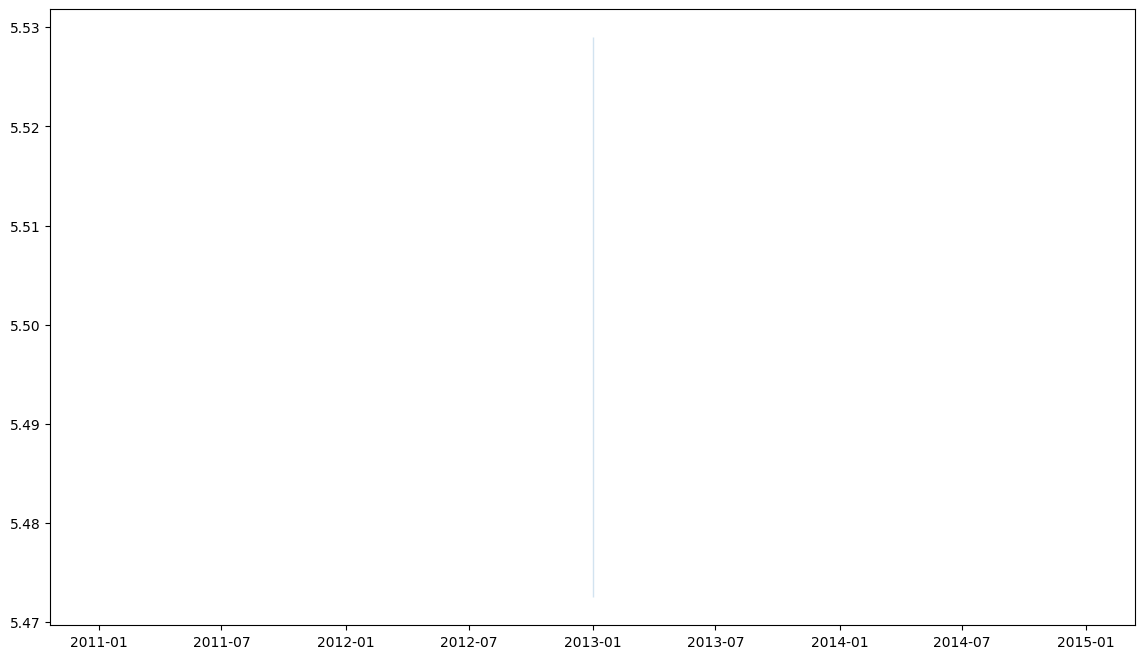

In [22]:
plot_store_status_over_time(df_sales)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_store_status(df):
    # Ensure that 'date' is a datetime object
    df["date"] = pd.to_datetime(df["date"])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Map store status to meaningful names for better labeling
    status_labels = {0: "Open", 2: "New", 4: "Closed", 6: "Old", 8: "Never Opened"}

    # Iterating through each store to plot their status over time
    for store in df["store_nbr"].unique():
        store_data = df[df["store_nbr"] == store]
        ax.plot(
            store_data["date"],
            store_data["store_status"],
            marker="o",
            label=f"Store {store}",
        )

    # Format the x-axis to show dates properly
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    # Set labels and title
    ax.set_ylabel("Store Status")
    ax.set_xlabel("Date")
    ax.set_title("Store Status Over Time")
    ax.set_yticks(list(status_labels.keys()))
    ax.set_yticklabels(status_labels.values())

    # Add a legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show grid
    ax.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
plot_store_status(df_sales)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_store_status_area(df):
    # Ensure that 'date' is a datetime object
    df["date"] = pd.to_datetime(df["date"])

    # Create a pivot table for plotting
    pivot_df = df.pivot_table(
        index="date", columns="store_nbr", values="store_status", aggfunc="first"
    )

    # Create an area plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.5)

    # Set labels and title
    plt.ylabel("Store Status")
    plt.xlabel("Date")
    plt.title("Store Status Over Time (Area Plot)")
    plt.yticks(list(status_labels.keys()), list(status_labels.values()))

    # Add a legend
    plt.legend(title="Store Number", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
plot_store_status_area(df_sales)

In [ ]:
df_sales.head(30)

In [ ]:
df_sales.sample(60)

,store_nbr,item_nbr,date,unit_sales,store_status
32697713,5,1466039,2016-02-28,NaN,0
2978868,1,1174923,2016-05-21,2.000,0
12665904,2,1957773,2015-04-21,NaN,0
5350858,1,1915102,2017-05-06,NaN,0
16592877,3,1157685,2017-03-06,1.000,0
10692387,2,1686637,2014-08-19,NaN,0
21842427,4,563654,2016-10-27,4.000,0
23741971,4,1243817,2013-09-09,NaN,0
39572827,6,2010755,2015-11-10,NaN,0
15858192,3,793345,2016-01-26,NaN,0


# 6 Define New product for step 4.4

•	Before the very first sale of an item, all observations are kept as NA

•	After the very first sale of an item, we go to step 3:  

 Sum/Agg all sales group  by item, date
 --> Sum_sales > 0 then first_sales_day of product
 else <first_sales_day of product --> delete unit_sales --> N/A

In [ ]:
df_sales.drop(columns=["store_status"])

In [16]:
def merge_item_status(df):

    start_time = time.time()  # Record the start time of the function

    # Label Variable for atributing numbers to store status, to save memory in df
    EXISTING = 1
    NEW = 3
    # TEMPORARY_NOT_SOLD = 5 #---> Myabe to label delivery problems? for longer periods of stockout
    OLD = 7
    NEVER_SOLD = 9

    # Sort by store, item, and date --> is this needed???
    df_grouped = df.sort_values(["store_nbr", "item_nbr", "date"])

    # Create a new column for item status, label all items as 'existing' by default
    df_grouped["item_status"] = EXISTING

    # Find the first and last day with sales for each item per store
    first_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0]
        .groupby(["store_nbr", "item_nbr"])["date"]
        .min()
    )

    last_sale_date = (
        df_grouped[df_grouped["unit_sales"] > 0]
        .groupby(["store_nbr", "item_nbr"])["date"]
        .max()
    )

    # Loop through store-item combinations and label them as 'new' or 'old' based on first and last sale date
    for store in df_grouped["store_nbr"].unique():

        current_time = time.time()
        elapsed_time = current_time - start_time
        print(
            f"Processing current store number: {store} | Elapsed time: {elapsed_time:.2f} seconds"
        )

        for item in df_grouped[df_grouped["store_nbr"] == store]["item_nbr"].unique():

            store_item_data = df_grouped[
                (df_grouped["store_nbr"] == store) & (df_grouped["item_nbr"] == item)
            ]

            if (store, item) in first_sale_date.index:
                first_date = first_sale_date[(store, item)]
                last_date = last_sale_date[(store, item)]

                # Mark as 'NEW' before first sale date
                df_grouped.loc[
                    (df_grouped["store_nbr"] == store)
                    & (df_grouped["item_nbr"] == item)
                    & (df_grouped["date"] < first_date),
                    "item_status",
                ] = NEW

                # Mark as 'OLD' after last sale date
                df_grouped.loc[
                    (df_grouped["store_nbr"] == store)
                    & (df_grouped["item_nbr"] == item)
                    & (df_grouped["date"] > last_date),
                    "item_status",
                ] = OLD

            else:
                # Mark as 'NEVER_SOLD' If an item never had any sales
                df_grouped.loc[
                    (df_grouped["store_nbr"] == store)
                    & (df_grouped["item_nbr"] == item),
                    "item_status",
                ] = NEVER_SOLD  # --> DELETE? ITEM FROM STORE? example item_nbr 2011451 from store_nbr 6
                # to-do: investigate if never_sold items are created beceause of NaN function

    # Change the data type of store_status column to int8
    df_grouped["item_status"] = df_grouped["item_status"].astype("int8")

    # Merging item_status on df
    df = df.merge(
        df_grouped[["store_nbr", "item_nbr", "date", "item_status"]],
        left_on=["store_nbr", "item_nbr", "date"],
        right_on=["store_nbr", "item_nbr", "date"],
        how="left",
    )

    end_time = time.time()
    total_time = end_time - start_time
    print("-" * 72)
    print(
        f"Size of df:     {round(sys.getsizeof(df)/1024/1024/1024, 2)} GB and end observations:       {round(df.shape[0] / 1e6, 1)} million."
    )
    print("- " * 36)
    print(f"Total execution time: {total_time / 60 / 60:.2f} hours")
    print("-" * 72)

    return df

- Processing current store number: 1 | Elapsed time: 15.05 seconds
- Processing current store number: 2 | Elapsed time: 2210.48 seconds
- Processing current store number: 3 | Elapsed time: 4455.33 seconds
- Processing current store number: 4 | Elapsed time: 6553.91 seconds
- Processing current store number: 5 | Elapsed time: 8607.63 seconds
- Processing current store number: 6 | Elapsed time: 10650.11 seconds
------------------------------------------------------------------------
- Size of df:     0.95 GB and end observations:       40.9 million.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- Total execution time: 12732.79 seconds
------------------------------------------------------------------------


In [20]:
# very time consuming function! takes sometimes more then 2000 minutes per store

df_sales = merge_item_status(df_sales)

Processing current store number: 1 | Elapsed time: 1.76 seconds
------------------------------------------------------------------------
Size of df:     0.16 GB and end observations:       6.8 million.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total execution time: 0.12 hours
------------------------------------------------------------------------


In [21]:
df_sales.head(30)

,store_nbr,item_nbr,date,unit_sales,item_status
0,1,103665,2013-01-01,NaN,3
1,1,103665,2013-01-02,2.0,1
2,1,103665,2013-01-03,3.0,1
3,1,103665,2013-01-04,2.0,1
4,1,103665,2013-01-05,4.0,1
5,1,103665,2013-01-06,2.0,1
6,1,103665,2013-01-07,1.0,1
7,1,103665,2013-01-08,NaN,1
8,1,103665,2013-01-09,1.0,1
9,1,103665,2013-01-10,6.0,1


In [22]:
df_sales.tail(30)

,store_nbr,item_nbr,date,unit_sales,item_status
40876578,6,2011451,2017-07-17,NaN,9
40876579,6,2011451,2017-07-18,NaN,9
40876580,6,2011451,2017-07-19,NaN,9
40876581,6,2011451,2017-07-20,NaN,9
40876582,6,2011451,2017-07-21,NaN,9
40876583,6,2011451,2017-07-22,NaN,9
40876584,6,2011451,2017-07-23,NaN,9
40876585,6,2011451,2017-07-24,NaN,9
40876586,6,2011451,2017-07-25,NaN,9
40876587,6,2011451,2017-07-26,NaN,9


In [23]:
df_sales.sample(60)

,store_nbr,item_nbr,date,unit_sales,item_status
40563797,6,2048242,2016-03-03,NaN,3
17953180,3,1717640,2016-07-24,1.000,1
17157806,3,1472484,2015-09-02,3.000,1
4377794,1,1533364,2015-03-22,NaN,1
27146118,4,2087567,2016-10-22,NaN,3
24355051,4,1696036,2014-08-11,NaN,9
905329,1,1047790,2014-07-16,12.000,1
22468115,4,843609,2015-04-16,1.000,1
25291219,4,1398687,2017-05-23,NaN,7
37412699,6,1342009,2017-04-05,2.000,1


# 7. Stockout on store level for 4.8 for perishable and non-perishable items

•      Perishable good: when there are missing values for two consecutive days for a given item per individual store 

•      Nonperishable goods: when there are missing values for 7 consecutive days for a given item and per individual store

•      Action: Impute with algorithm 

In [ ]:
#perishable good
if ['perishable'] == 1 and item_missing_count = 1  #-->  inpute with 0

if ['perishable'] == 1 and item_missing_count > 2  #-->  inpute with 0

if ['perishable'] == 1 and item_missing_count <= 2 #-->  inpute with mean? or intrapolate?


    
#non-perishable good  
if ['perishable'] == 0 and and item_missing_count > 7 #-->  inpute with 0?

if ['perishable'] == 0 and item_missing_count <= 7 #-->  inpute with mean? or intrapolate?

First function to impute stockouts, first needed to merge with item for perishable column

In [15]:
df_sales = df_sales.merge(df_items, left_on="item_nbr", right_on="item_nbr", how="left")

df_sales = df_sales.drop(columns=["family", "class"])

In [16]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367889472 entries, 0 to 367889471
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   store_nbr   uint8         
 1   item_nbr    uint32        
 2   date        datetime64[ns]
 3   unit_sales  float32       
 4   perishable  uint8         
dtypes: datetime64[ns](1), float32(1), uint32(1), uint8(2)
memory usage: 6.2 GB


In [ ]:
def impute_stockouts(df):
    # Sort the dataframe by date, store_nbr, and item_nbr
    df = df.sort_values(["store_nbr", "item_nbr", "date"])

    # Group by store_nbr and item_nbr
    df_grouped = df.groupby(["store_nbr", "item_nbr"])

    def impute_group(group):

        # Calculate the number of consecutive missing days
        group["missing_count"] = (
            group["unit_sales"]
            .isnull()  # checks for null values in unit_sales
            .astype(int)
            .groupby(
                (group["unit_sales"].notnull().astype(int).diff() != 0).cumsum()
            )  # First occurrence, so each streak of consecutive nulls or non-nulls gets a unique number
            .cumsum()  # Counts consecutive nulls within each group
        )

        # Imputation logic for perishable goods if = 1
        perishable_mask = group["perishable"] == 1
        group.loc[perishable_mask & (group["missing_count"] == 1), "unit_sales"] = 0
        group.loc[perishable_mask & (group["missing_count"] > 2), "unit_sales"] = 0
        group.loc[perishable_mask & (group["missing_count"] == 2), "unit_sales"] = (
            group.loc[perishable_mask, "unit_sales"].interpolate()
        )

        # Imputation logic for non-perishable goods if = 0
        non_perishable_mask = group["perishable"] == 0
        group.loc[non_perishable_mask & (group["missing_count"] > 7), "unit_sales"] = 0
        group.loc[non_perishable_mask & (group["missing_count"] <= 7), "unit_sales"] = (
            group.loc[non_perishable_mask, "unit_sales"].interpolate()
        )

        # Drop temporary missing count column
        group = group.drop("missing_count", axis=1)

        return

    # Apply the imputation to each group
    imputed_df = df_grouped.apply(impute_group).reset_index(drop=True)

    return imputed_df

In [22]:
def impute_group(group):

    # Calculate the number of consecutive missing days
    group["missing_count"] = (
        group["unit_sales"]
        .isnull()  # checks for null values in unit_sales
        .astype(int)
        .groupby(
            (group["unit_sales"].notnull().astype(int).diff() != 0).cumsum()
        )  # First occurrence, so each streak of consecutive nulls or non-nulls gets a unique number
        .cumsum()  # Counts consecutive nulls within each group
    )

    # Imputation logic for perishable goods if 1
    perishable_mask = group["perishable"] == 1
    group.loc[perishable_mask & (group["missing_count"] == 1), "unit_sales"] = 0
    group.loc[perishable_mask & (group["missing_count"] > 2), "unit_sales"] = 0
    group.loc[perishable_mask & (group["missing_count"] == 2), "unit_sales"] = (
        group.loc[perishable_mask, "unit_sales"].interpolate()  # to-do: Interpolate ()
    )

    # Imputation logic for non-perishable goods if 0
    non_perishable_mask = group["perishable"] == 0
    group.loc[non_perishable_mask & (group["missing_count"] > 7), "unit_sales"] = 0
    group.loc[non_perishable_mask & (group["missing_count"] <= 7), "unit_sales"] = (
        group.loc[
            non_perishable_mask, "unit_sales"
        ].interpolate()  # To-do: Interpolate ()
    )

    # Drop temporary missing count column
    group = group.drop("missing_count", axis=1)

    return group

In [23]:
def impute_stockouts(df):
    # Sort the dataframe by date, store_nbr, and item_nbr
    df = df.sort_values(["store_nbr", "item_nbr", "date"])

    # Group by store_nbr and item_nbr
    df_grouped = df.groupby(["store_nbr", "item_nbr"])

    # Apply the imputation to each group
    imputed_df = df_grouped.apply(impute_group).reset_index(drop=True)

    return imputed_df

In [29]:
df_sales_test = df_sales[df_sales["item_nbr"].isin([103665, 1398687, 2011451])]

In [30]:
df_sales_test = impute_stockouts(df_sales_test)

C:\Users\alexander\AppData\Local\Temp\ipykernel_20696\612087311.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  imputed_df = df_grouped.apply(impute_group).reset_index(drop=True)


In [31]:
df_sales_test.head(20)

,store_nbr,item_nbr,date,unit_sales,item_status,perishable
0,1,103665,2013-01-01,0.0,3,1
1,1,103665,2013-01-02,2.0,1,1
2,1,103665,2013-01-03,3.0,1,1
3,1,103665,2013-01-04,2.0,1,1
4,1,103665,2013-01-05,4.0,1,1
5,1,103665,2013-01-06,2.0,1,1
6,1,103665,2013-01-07,1.0,1,1
7,1,103665,2013-01-08,0.0,1,1
8,1,103665,2013-01-09,1.0,1,1
9,1,103665,2013-01-10,6.0,1,1


In [32]:
df_sales_test.tail(20)

,store_nbr,item_nbr,date,unit_sales,item_status,perishable
5044,1,2011451,2017-07-27,0.0,9,0
5045,1,2011451,2017-07-28,0.0,9,0
5046,1,2011451,2017-07-29,0.0,9,0
5047,1,2011451,2017-07-30,0.0,9,0
5048,1,2011451,2017-07-31,0.0,9,0
5049,1,2011451,2017-08-01,0.0,9,0
5050,1,2011451,2017-08-02,0.0,9,0
5051,1,2011451,2017-08-03,0.0,9,0
5052,1,2011451,2017-08-04,0.0,9,0
5053,1,2011451,2017-08-05,0.0,9,0


In [33]:
df_sales_test.sample(60)

,store_nbr,item_nbr,date,unit_sales,item_status,perishable
658,1,103665,2014-10-21,1.000000,1,1
2816,1,1398687,2016-02-03,0.000000,1,0
2918,1,1398687,2016-05-15,1.000000,1,0
49,1,103665,2013-02-19,3.000000,1,1
482,1,103665,2014-04-28,1.000000,1,1
2839,1,1398687,2016-02-26,4.000000,1,0
1787,1,1398687,2013-04-10,0.000000,3,0
4337,1,2011451,2015-08-20,0.000000,9,0
623,1,103665,2014-09-16,8.000000,1,1
2135,1,1398687,2014-03-24,0.000000,3,0


In [1]:
df_sales_test.info()

NameError: name 'df_sales_test' is not defined

In [ ]:
# Interpolate between missing datapoints --> sales

fillna(method="mean")

df["column_name"].interpolate(method="linear", inplace=True)

df["column_name"].interpolate(method="time", inplace=True)

df["column_name"].interpolate(method="polynomial", order=2, inplace=True)

# Interpolate missing values for the 'unit_sales' column
df["unit_sales"] = df.groupby(["store_nbr", "item_nbr"])["unit_sales"].apply(
    lambda group: group.interpolate(method="linear")
)

# 8. Promotion Count

The number of days a item was on promotion 

In [ ]:
# df["year"] = df["date"].dt.year
# df["month"] = df["date"].dt.month
# df["day"] = df["date"].dt.day

# Adding week number feature
df_sales["week_number"] = df_sales["date"].dt.isocalendar().week

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


# Example 3: Line plot of missing values over time
def plot_missing_values_time(df):
    missing_over_time = df.set_index("date")["onpromotion"].isnull().resample("D").sum()
    plt.figure(figsize=(12, 6))
    plt.plot(missing_over_time.index, missing_over_time.values)
    plt.title("Missing Values in onpromotion Column Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Missing Values")
    plt.show()

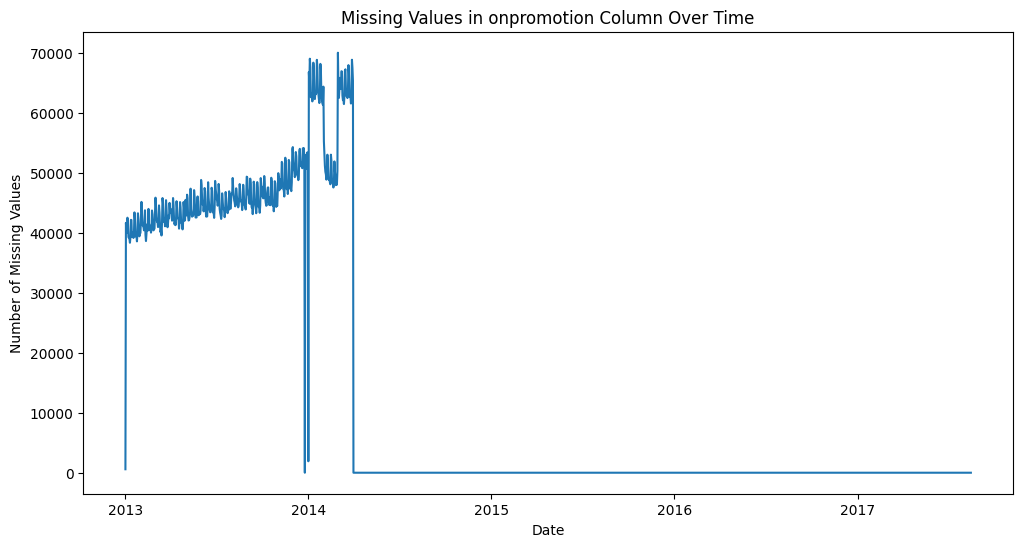

In [16]:
df = df_sales

plot_missing_values_time(df)

In [ ]:
df_sales.info()

# X.X df_sales_agg_week code to test

In [ ]:
# Group the DataFrame by store number, item number, year, and week number, then aggregate the columns:
# --> "unit_sales","onpromotion", "national_hol","regional_hol","local_hol", "closed_hol",


def df_sales_agg_week(df):


    # Pre-sort the DataFrame, should be faster?

    df = df.sort_values(["store_nbr", "item_nbr", "year", "week_number"])


    df = (

        df.groupby(
            [
                "store_nbr",
                "item_nbr",

                "year",
                "week_number",
            ],

            sort=False,  # We've already sorted, so no need to sort again/double
        )
        .agg(
            {
                "unit_sales": "sum",
                "onpromotion": "sum",
                "national_hol": "sum",
                "regional_hol": "sum",
                "local_hol": "sum",
                "closed_hol": "sum",
            }
        )

        .reset_index()
    )


    return df

# 9. Closed Holiday Column Feature

The number of closed holidays within the week, expressed in percentages